In [7]:
import torch, torchvision
from torchvision import transforms
from torcheval.metrics import MulticlassAccuracy, MulticlassConfusionMatrix
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path
import time, json, random, numpy as np

1 Paths & hyper-params

In [8]:
DATA_DIR   = Path("../data/exports")     # adjust if notebook root differs
BS         = 64
LR         = 1e-3
EPOCHS     = 35
patience = 8
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

 Transforms & loaders

In [9]:
train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4,
                           saturation=0.3, hue=0.05),
    transforms.RandomResizedCrop(100, scale=(0.75, 1.0)),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),   # mild blur / rain
    transforms.ToTensor()
])
val_tf = transforms.ToTensor()

train_ds = torchvision.datasets.ImageFolder(DATA_DIR/"train", transform=train_tf)
val_ds   = torchvision.datasets.ImageFolder(DATA_DIR/"val",   transform=val_tf)
test_ds  = torchvision.datasets.ImageFolder(DATA_DIR/"test",  transform=val_tf)

train_ld = torch.utils.data.DataLoader(train_ds, BS, shuffle=True,  num_workers=2)
val_ld   = torch.utils.data.DataLoader(val_ds,   BS, shuffle=False, num_workers=2)
test_ld  = torch.utils.data.DataLoader(test_ds,  BS, shuffle=False, num_workers=2)

print(f"train {len(train_ds)}  val {len(val_ds)}  test {len(test_ds)}")


train 50589  val 14453  test 7226


Weighted Loss

In [10]:
from collections import Counter

# compute class–balance weights once
counts = Counter([lbl for _, lbl in train_ds.samples])   # {0:neg, 1:pos}
print(counts)
total  = counts[0] + counts[1]
weights = torch.tensor([
    total / (2 * counts[0]),          # weight for class 0 (neg)
    total / (2 * counts[1])           # weight for class 1 (pos)
], dtype=torch.float32).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=weights)

Counter({0: 25383, 1: 25206})


3 Model = Tiny EfficientNet-B0 (from torchvision)

In [12]:
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
from torch import nn

# 1️⃣ load ImageNet-pretrained backbone
weights = EfficientNet_B1_Weights.IMAGENET1K_V1      # or ".DEFAULT"
model   = efficientnet_b1(weights=weights)

# 2️⃣ swap the classifier to 2-class
in_feat = model.classifier[-1].in_features           # 1280 for B1
model.classifier[-1] = nn.Linear(in_feat, 2)

model = model.to(DEVICE)
optim    = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS)
#scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=3, gamma=0.5)

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to C:\Users\modar/.cache\torch\hub\checkpoints\efficientnet_b1_rwightman-bac287d4.pth


100%|██████████| 30.1M/30.1M [00:07<00:00, 4.35MB/s]


4 Training / validation loop

In [13]:
def run_epoch(loader, train=True):
    model.train(train)
    loss_sum, n = 0, 0
    metric = MulticlassAccuracy(num_classes=2).to(DEVICE)
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        if train:
            optim.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        if train:
            loss.backward()
            optim.step()
        loss_sum += loss.item() * x.size(0)
        n += x.size(0)
        metric.update(logits, y)
    return loss_sum / n, metric.compute().item()

best_val = 0
best_state = None
wait = 0
print(f"early-stop patience = {patience}")

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(train_ld, train=True)
    val_loss, val_acc = run_epoch(val_ld, train=False)
    scheduler.step()

    print(f"{epoch:02d} {tr_loss:.3f} {tr_acc:.3f} | {val_loss:.3f} {val_acc:.3f}  ({time.time() - t0:.1f}s)")

    if val_acc > best_val:
        best_val = val_acc
        best_state = model.state_dict()
        wait = 0
        print(f"New best_val: {best_val:.4f}")
    else:
        wait += 1
        if wait >= patience:
            print("Early-stop at epoch", epoch)
            break
model.load_state_dict(best_state)


early-stop patience = 8
01 0.349 0.854 | 0.269 0.894  (1406.3s)
New best_val: 0.8937
02 0.291 0.881 | 0.236 0.906  (1202.6s)
New best_val: 0.9063
03 0.275 0.888 | 0.223 0.915  (845.3s)
New best_val: 0.9155
04 0.259 0.895 | 0.237 0.912  (841.4s)
05 0.251 0.899 | 0.218 0.914  (843.5s)
06 0.244 0.903 | 0.203 0.920  (849.6s)
New best_val: 0.9195
07 0.234 0.907 | 0.196 0.921  (858.4s)
New best_val: 0.9210
08 0.225 0.911 | 0.194 0.926  (848.6s)
New best_val: 0.9260
09 0.217 0.913 | 0.196 0.922  (842.2s)
10 0.209 0.918 | 0.188 0.928  (847.0s)
New best_val: 0.9280
11 0.200 0.922 | 0.200 0.926  (850.5s)
12 0.193 0.925 | 0.197 0.926  (852.5s)
13 0.185 0.928 | 0.193 0.929  (849.5s)
New best_val: 0.9294
14 0.177 0.931 | 0.192 0.928  (855.8s)
15 0.170 0.936 | 0.182 0.929  (855.4s)
New best_val: 0.9294
16 0.161 0.938 | 0.181 0.932  (853.5s)
New best_val: 0.9321
17 0.156 0.942 | 0.183 0.933  (843.8s)
New best_val: 0.9326
18 0.148 0.944 | 0.171 0.936  (851.2s)
New best_val: 0.9363
19 0.136 0.948 | 0.1

<All keys matched successfully>

5 Test-set evaluation & confusion-matrix

Test accuracy: 0.9377248883247375


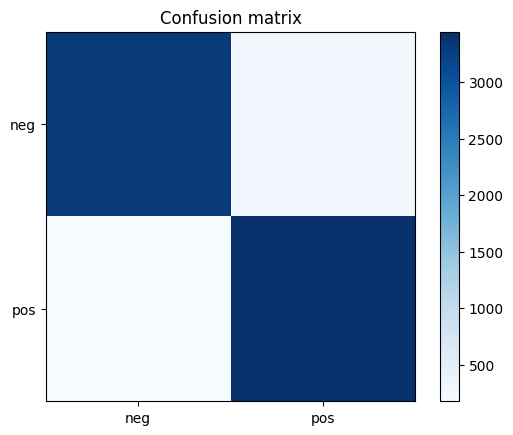

In [14]:
metric_acc = MulticlassAccuracy(num_classes=2).to(DEVICE)
metric_cm  = MulticlassConfusionMatrix(num_classes=2).to(DEVICE)

model.eval()
with torch.no_grad():
    for x, y in test_ld:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        metric_acc.update(logits, y)
        metric_cm.update(logits, y)

print("Test accuracy:", metric_acc.compute().item())

cm = metric_cm.compute().cpu().numpy()
plt.imshow(cm, cmap="Blues")
plt.xticks([0,1], ["neg","pos"]); plt.yticks([0,1], ["neg","pos"])
plt.colorbar(); plt.title("Confusion matrix"); plt.show()

6 Save model & metrics (optional)

In [18]:
Path("../models").mkdir(parents=True, exist_ok=True)
torch.save(best_state, "../models/efficientnet_best.pt")
with open("../models/final_metrics.json", "w") as f:
    json.dump({
        "accuracy": metric_acc.compute().item(),
        "class_counts": dict(counts),
        "best_val": best_val,
        "epochs_ran": epoch,
        "stopped_early": wait >= patience
    }, f, indent=2)

In [19]:
# ── 1.  Reload the checkpoint you just wrote ────────────────────────────
import torch, torchvision, torch.nn as nn
from torchvision.models import efficientnet_b1

chk_file = "../models/efficientnet_best.pt"        # ← the file you saved
print("Loading", chk_file)

# recreate the architecture exactly as during training
model = efficientnet_b1(weights=None, num_classes=2)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)

state = torch.load(chk_file, map_location="cpu")
model.load_state_dict(state, strict=True)
model.eval()
print("✓ checkpoint OK – params:", sum(p.numel() for p in model.parameters()))

# ── 2.  Quick sanity-check on one tile ──────────────────────────────────
from PIL import Image
tile = "../data/exports/val/pos/" + next(iter((Path("../data/exports/val/pos").glob("*.png")))).name
img = Image.open(tile).convert("RGB")
tensor = val_tf(img).unsqueeze(0)           # reuse the same val_tf transform

with torch.no_grad():
    prob_roi = torch.softmax(model(tensor), dim=1)[0, 1].item()

print(f"{Path(tile).name}  →  ROI probability = {prob_roi:.3f}")
# ROI tile should print ~0.9 ; pick a neg tile to see ~0.1


Loading ../models/efficientnet_best.pt
✓ checkpoint OK – params: 6515746
pos_000000.png  →  ROI probability = 0.881
